### Leanring of two unknown attractors given known sequence segments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.util import optimize_tools, load_tools, process_tools
from src.lpvds.src.lpvds_class import lpvds_class

from scipy.stats import multivariate_normal

# %matplotlib tk


In [2]:
'''Load data'''
p_raw, q_raw, t_raw, dt = load_tools.load_npy()
'''Process data'''
p_in, q_in, t_in             = process_tools.pre_process(p_raw, q_raw, t_raw, opt= "savgol")
p_out, q_out                 = process_tools.compute_output(p_in, q_in, t_in)
p_init, q_init, p_att, q_att = process_tools.extract_state(p_in, q_in)
p_in, q_in, p_out, q_out     = process_tools.rollout_list(p_in, q_in, p_out, q_out)

In [3]:
x = p_in
x_dot = p_out
x_att = p_att
x_init = p_init

N1 = 100
sequence_arr = np.zeros((p_in.shape[0], ), dtype=int)
sequence_arr[N1: ] = 1


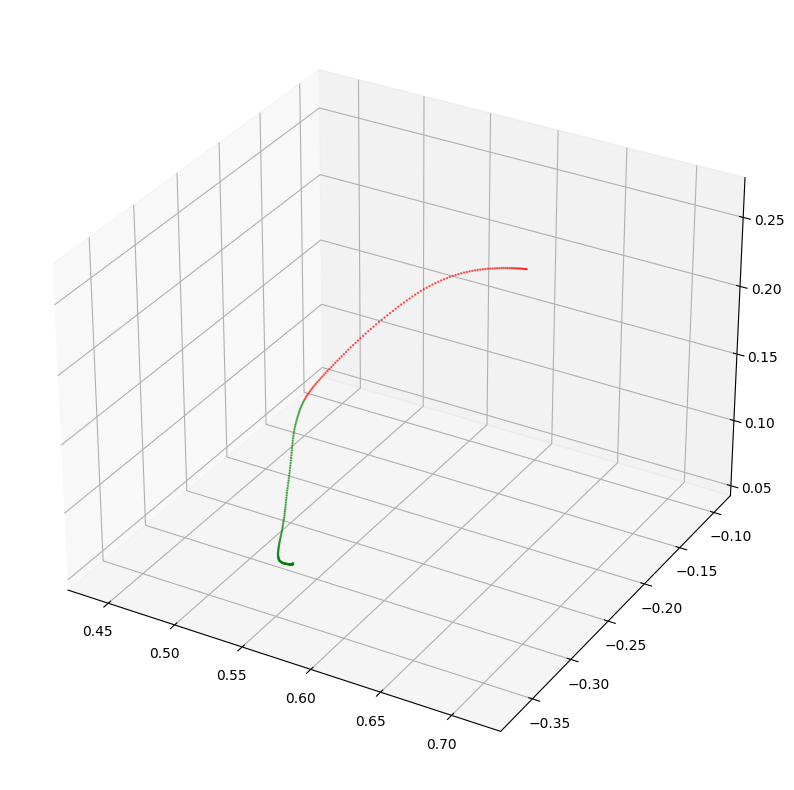

In [4]:
x_1 = x[sequence_arr==0, :]
x_dot_1 = x_dot[sequence_arr==0, :]


x_2 = x[sequence_arr==1, :]
x_dot_2 = x_dot[sequence_arr==1, :]



colors = ["r", "g", "b", "k", 'c', 'm', 'y', 'crimson', 'lime']
color_mapping = np.take(colors, sequence_arr)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], color=color_mapping[:], alpha= 0.6, s=0.5)
ax.axis('equal')
plt.show()

In [5]:
x_1 = x[sequence_arr==0, :]
x_dot_1 = x_dot[sequence_arr==0, :]

x_2 = x[sequence_arr==1, :]
x_dot_2 = x_dot[sequence_arr==1, :]


x_att_1 = x_1[-1, :] - 0.01 * np.random.rand(3,).reshape(1, -1) # Random initialization
# x_att_2 = x_att - 0.01 * np.random.rand(3,).reshape(1, -1) # Random initialization

x_att_2 = x_att.reshape(1, -1) # Random initialization

0
100


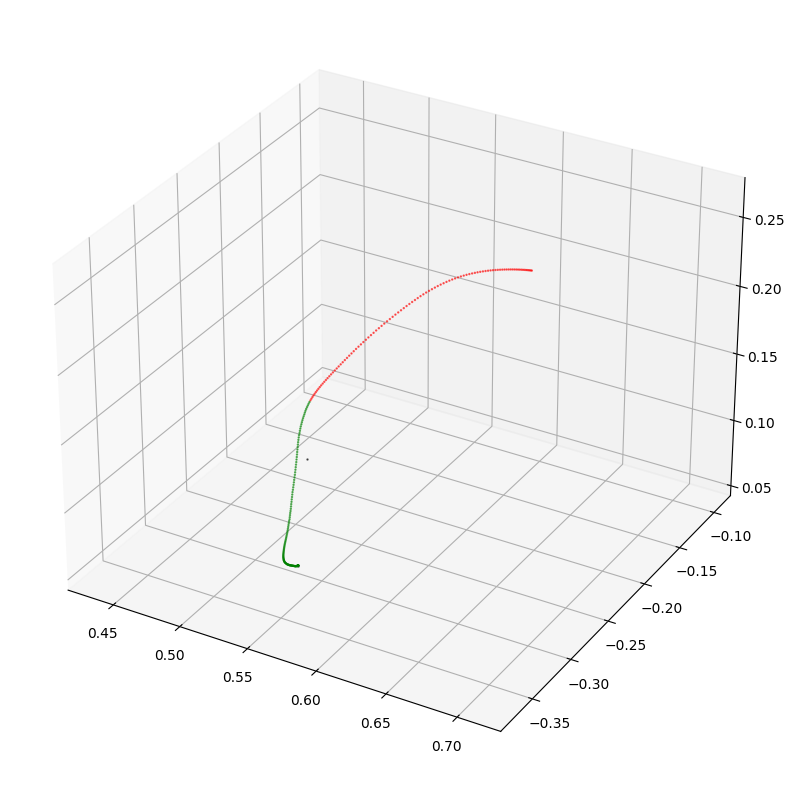

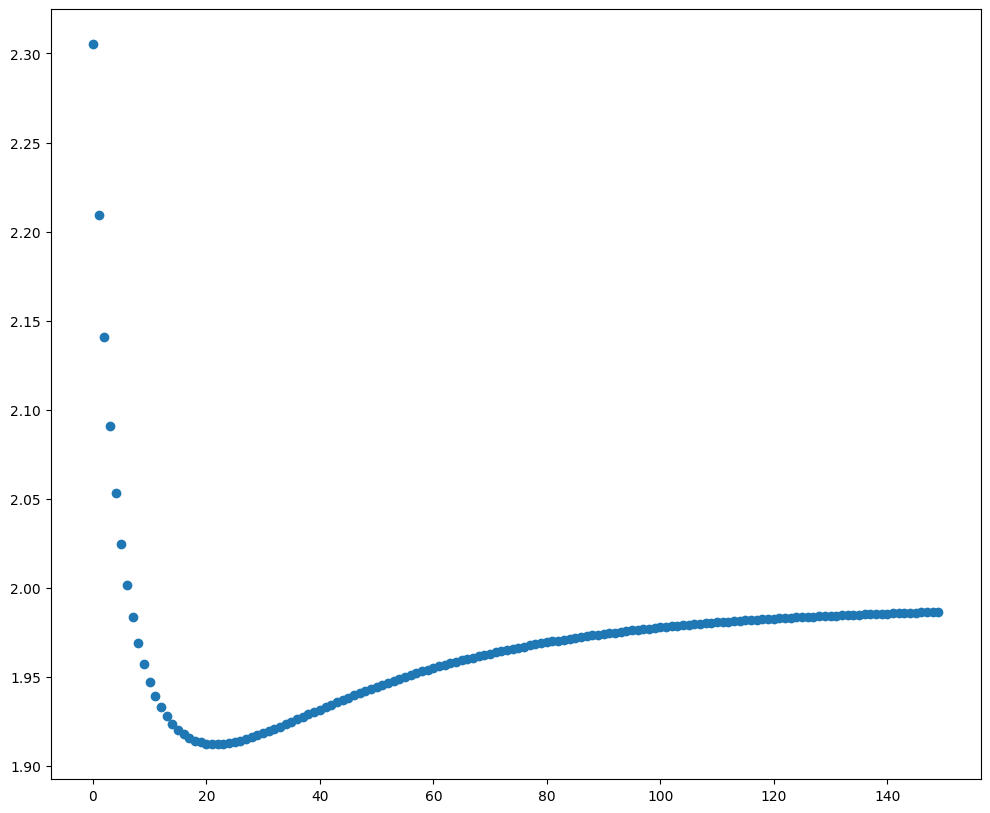

In [6]:
T = 150
x_att_list = []
MSE_list = []
for i in range(T):
    P_1 = optimize_tools._optimize_P(x_1-x_att_1, x_dot_1, np.zeros((x_1.shape[0], ), dtype=int))
    A_1 = optimize_tools.optimize_A(x_1, x_dot_1, x_att_1, gamma=np.ones((1, x_1.shape[0]), dtype=int), P=P_1)
    x_att_1 = optimize_tools.optimize_att(x_1, x_dot_1, A_1)

    # P_2 = optimize_tools._optimize_P(x_2-x_att_2, x_dot_2, np.zeros((x_2.shape[0], ), dtype=int))
    # A_2 = optimize_tools.optimize_A(x_2, x_dot_2, x_att_2, gamma=np.ones((1, x_2.shape[0]), dtype=int), P=P_2)
    # x_att_2 = optimize_tools.optimize_att(x_2, x_dot_2, A_2)

    # x_att_2 = optimize_tools.optimize_att(x_2, x_dot_2, A_2)
    if i%100==0:
        print(i)

    x_dot_1_pred = A_1[0] @ (x_1 - x_att_1).T
    MSE_list.append(np.sum(np.linalg.norm(x_dot_1_pred-x_dot_1.T, axis=0)))

A_2 = optimize_tools.optimize_A(x_2, x_dot_2, x_att_2)


colors = ["r", "g", "b", "k", 'c', 'm', 'y', 'crimson', 'lime']
color_mapping = np.take(colors, sequence_arr)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], color=color_mapping[:], alpha= 0.6, s=0.5)
ax.scatter(x_att_1[:, 0], x_att_1[:, 1], x_att_1[:, 2], color='k', alpha= 0.6, s=0.5)
ax.scatter(x_att_2[:, 0], x_att_2[:, 1], x_att_2[:, 2], color='k', alpha= 0.6, s=0.5)

ax.axis('equal')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot()
ax.scatter(np.arange(T), np.array(MSE_list))
plt.show()

In [7]:
n_S = 2 # number of S
M = x.shape[0]

alpha = np.zeros((M, n_S))

In [8]:
# Termination probability P(b=1|s, x)

thld = 0.04
# for i in range(x.shape[0]):
transitionMat = np.zeros((x.shape[0]-1, 2, 2)) # from column to row; A_ij = P(s_ip1 = si|s_i=s_j)

for i in np.arange(1, x.shape[0]):
# for i in [1]:
    x_i = x[i, :]

    #P(b_i=1|s_i=s1)
    p_b_1_s1 = 1 if np.linalg.norm(x_i - x_2[0, :]) < thld else 0
    #P(b_i=0|s_i=s1)
    p_b_0_s1 = 1 - p_b_1_s1

    #P(b_i=1|s_i=s2)
    p_b_1_s2 = 1 if np.linalg.norm(x_i -x_2[-1, :]) < thld else 0
    #P(b_i=0|s_i=s2)
    p_b_0_s2 = 1 - p_b_1_s2


    #P(s_ip1=s2|s_i=s1, b_i=1)
    p_s_ip1_s2_s_i_s1_b_1 = 1
    #P(s_ip1=s2|s_i=s1, b_i=0)
    p_s_ip1_s2_s_i_s1_b_0 = 0

    #P(s_ip1=s1|s_i=s1, b_i=1) 
    p_s_ip1_s1_s_i_s1_b_1 = 0
    #P(s_ip1=s1|s_i=s1, b_i=0)
    p_s_ip1_s1_s_i_s1_b_0 = 1

    #P(s_ip1=s2|s_i=s2, b_i=1) 
    p_s_ip1_s2_s_i_s2_b_1 = 1 # special case because s2 is the last state, so it always remains regardless
    #P(s_ip1=s2|s_i=s2, b_i=0)
    p_s_ip1_s2_s_i_s2_b_0 = 1


    """Integrate over all possible b_i given s_i"""
    #P(s_ip1=s1|s_i=s1) = P(s_ip1=s1|s_i=s1, b_i=0) * P(b_i=0|s_i=s1) + P(s_ip1=s1|s_i=s1, b_i=1) * P(b_i=1|s_i=s1)

    P_s_ip1_s1_s_i_s1 =  p_s_ip1_s1_s_i_s1_b_0 * p_b_0_s1 + p_s_ip1_s1_s_i_s1_b_1 * p_b_1_s1

    #P(s_ip1=s2|s_i=s1) = 0 * x + 1 * y
    P_s_ip1_s2_s_i_s1 =  p_s_ip1_s2_s_i_s1_b_0 * p_b_0_s1 + p_s_ip1_s2_s_i_s1_b_1 * p_b_1_s1
    # print(np.linalg.norm(x_i - x_att_2))


    #P(s_ip1=s1|s_i=s2)
    P_s_ip1_s1_s_i_s2 = 1


    #P(s_ip1=s2|s_i=s2) = P(s_ip1=s2|s_i=s2, b_i=0) * P(b_i=0|s_i=s2) + P(s_ip1=s2|s_i=s2, b_i=1) * P(b_i=1|s_i=s2)
    P_s_ip1_s2_s_i_s2 = p_s_ip1_s2_s_i_s2_b_0 * p_b_0_s2 + p_s_ip1_s2_s_i_s2_b_1 * p_b_1_s2


    transitionMat[i-1, 0, 0] = P_s_ip1_s1_s_i_s1
    transitionMat[i-1, 0, 1] = P_s_ip1_s1_s_i_s2
    transitionMat[i-1, 1, 0] = P_s_ip1_s2_s_i_s1
    transitionMat[i-1, 1, 1] = P_s_ip1_s2_s_i_s2



In [9]:
mu_1 = np.mean(x_1, axis=0)
Sigma_1 = np.cov(x_1.T)
# Sigma_1 = adjust_cov(Sigma_1)

mu_2 =  np.mean(x_2, axis=0)
Sigma_2 = np.cov(x_2.T)
# Sigma_2 = adjust_cov(Sigma_2)

cov_em_1 = np.cov((x_dot_1.T - (A_1[0] @ (x_1-x_att_1).T)))

cov_em_2 = np.cov((x_dot_2.T - (A_2[0] @ (x_2-x_att_2).T)))

emissionMat = np.zeros((x.shape[0], 2)) 
# for i in [0, 1]:
for i in range(x.shape[0]):
    x_i = x[i, :]
    x_dot_i = x_dot[i, :]

    #P(x_ip1|s_ip1=s1) 
    P_x_ip1_s_ips_s1 = multivariate_normal.logpdf(x_i, mean=mu_1, cov=Sigma_1, allow_singular=True)

    #P(x_ip1|s_ip1=s2) 
    P_x_ip1_s_ips_s2 = multivariate_normal.logpdf(x_i, mean=mu_2, cov=Sigma_2, allow_singular=True)

    #P(x_dot_ip1|x_ip1, s_ip1=s1)
    mu_em_1 = A_1[0] @ (x_i.reshape(1, -1) - x_att_1).T

    normal_1 = multivariate_normal(mean=mu_em_1[:, 0], cov=cov_em_1, allow_singular=True)
    P_x_dot_ip1_x_ip1_s_ip1_s1 = normal_1.logpdf(x_dot_i)

    # P_x_dot_ip1_x_ip1_s_ip1_s1 =  multivariate_normal.logpdf(x_dot_i, mean=mu_em_1[:, 0], cov=cov_em_1, allow_singular=True)

    #P(x_dot_ip1|x_ip1, s_ip1=s2)
    mu_em_2 = A_2[0] @ (x_i.reshape(1, -1) - x_att_2).T
    P_x_dot_ip1_x_ip1_s_ip1_s2 =  multivariate_normal.logpdf(x_dot_i, mean=mu_em_2[:, 0], cov=cov_em_2, allow_singular=True)


    #P(x_ip1, x_dot_ip1|s_ip1=s1) = P(x_dot_ip1|x_ip1, s_ip1=s1) * P(x_ip1|s_ip1=s1) 
    # P_x_ip1_x_dot_ip1_s_ip1_s1 = P_x_dot_ip1_x_ip1_s_ip1_s1 * P_x_ip1_s_ips_s1
    P_x_ip1_x_dot_ip1_s_ip1_s1 = P_x_dot_ip1_x_ip1_s_ip1_s1 + P_x_ip1_s_ips_s1

    #P(x_ip1, x_dot_ip1|s_ip1=s2) = P(x_dot_ip1|x_ip1, s_ip1=s2) * P(x_ip1|s_ip1=s2) 
    # P_x_ip1_x_dot_ip1_s_ip1_s2 = P_x_dot_ip1_x_ip1_s_ip1_s2 * P_x_ip1_s_ips_s2
    P_x_ip1_x_dot_ip1_s_ip1_s2 = P_x_dot_ip1_x_ip1_s_ip1_s2 + P_x_ip1_s_ips_s2

    emissionMat[i, 0] = P_x_ip1_x_dot_ip1_s_ip1_s1
    emissionMat[i, 1] = P_x_ip1_x_dot_ip1_s_ip1_s2

print(emissionMat)

[[ 1.49107904e+01 -1.01029851e+04]
 [ 1.59091389e+01 -9.86391439e+03]
 [ 1.69097929e+01 -9.56981552e+03]
 [ 1.77155688e+01 -9.30367477e+03]
 [ 1.86314209e+01 -8.99165116e+03]
 [ 1.93647072e+01 -8.70472654e+03]
 [ 2.00669112e+01 -8.41150003e+03]
 [ 2.07208047e+01 -8.09262935e+03]
 [ 2.11115105e+01 -7.83628275e+03]
 [ 2.17006838e+01 -7.52836418e+03]
 [ 2.21227797e+01 -7.23386334e+03]
 [ 2.23463311e+01 -6.96193302e+03]
 [ 2.26952590e+01 -6.66020454e+03]
 [ 2.30015018e+01 -6.34963508e+03]
 [ 2.30906741e+01 -6.09607265e+03]
 [ 2.31402214e+01 -5.82576870e+03]
 [ 2.32817272e+01 -5.54277717e+03]
 [ 2.33195645e+01 -5.27384785e+03]
 [ 2.32355405e+01 -5.03969498e+03]
 [ 2.29080695e+01 -4.81959694e+03]
 [ 2.31095797e+01 -4.55331355e+03]
 [ 2.25569210e+01 -4.35875940e+03]
 [ 2.26440191e+01 -4.12709360e+03]
 [ 2.27664919e+01 -3.89097532e+03]
 [ 2.26510080e+01 -3.70006369e+03]
 [ 2.20861735e+01 -3.53557438e+03]
 [ 2.16760133e+01 -3.36142726e+03]
 [ 2.22523410e+01 -3.14423623e+03]
 [ 2.21966838e+01 -2

In [10]:
# alpha_1(s_1=s1) = P(x_0, x_dot_0, x_1, x_dot_1, s_1=s1) 
#                 = P(x_1, x_dot_1|s_1=s1) * (P(x_0, x_dot_0, s_0=s1)*P(s_1=s1|s_0=s1)+P(x_0, x_dot_0, s_0=s2)*P(s_1=s1|s_0=s2))


# alpha_0(s_0=s1) = P(x_0, x_dot_0, s_0=s1) = P(x_0, x_dot_0|s_0=s1) * P(s_0=s1)
alpha[0, 0] = emissionMat[0, 0] + np.log(1/2)

# alpha_0(s_0=s2) = P(x_0, x_dot_0, s_0=s2) = P(x_0, x_dot_0|s_0=s2) * P(s_0=s2)
alpha[0, 1] = emissionMat[0, 1] + np.log(1/2)

# normalize

logProb = alpha[0, :].reshape(-1, 1)
maxPostLogProb = np.max(logProb, axis=0, keepdims=True)
expProb = np.exp(logProb - np.tile(maxPostLogProb, (2, 1)))
postProb = expProb / np.sum(expProb, axis = 0, keepdims=True)


alpha[0, :] = postProb[:, 0]


for i in np.arange(1, alpha.shape[0]):
# for i in [1]:
    # alpha[1, 0] = P_x_ip1_x_dot_ip1_s_ip1_s1 * (alpha[0,0] * P_s_ip1_s1_s_i_s1 + alpha[0,1] * P_s_ip1_s1_s_i_s2)
    # alpha[i, 0] = emissionMat[i, 0] + np.log(alpha[i-1,0] * transitionMat[i-1, 0, 0] + alpha[i-1,1] * transitionMat[i-1, 0, 1])


    b_1 = np.log(alpha[i-1,0] * transitionMat[i-1, 0, 0] + alpha[i-1,1] * transitionMat[i-1, 0, 1])
    alpha[i, 0] = emissionMat[i, 0] 

    # alpha_1(s_1=s2) = P(x_0, x_dot_0, x_1, x_dot_1, s_1=s2) 
    #                 = P(x_1, x_dot_1|s_1=s1) * (P(x_0, x_dot_0, s_0=s1)*P(s_1=s2|s_0=s1)+P(x_0, x_dot_0, s_0=s2)*P(s_1=s2|s_0=s2))
    # alpha[i, 1] = emissionMat[i, 1] + np.log(alpha[i-1,0] * transitionMat[i-1, 1, 0] + alpha[i-1,1] * transitionMat[i-1, 1, 1])
    b_2 = np.log(alpha[i-1,0] * transitionMat[i-1, 1, 0] + alpha[i-1,1] * transitionMat[i-1, 1, 1])
    alpha[i, 1] = emissionMat[i, 1] 


    logProb = alpha[i, :].reshape(-1, 1)
    maxPostLogProb = np.max(logProb, axis=0, keepdims=True)
    expProb = np.exp(logProb - np.tile(maxPostLogProb, (2, 1)))
    postProb = expProb / np.sum(expProb, axis = 0, keepdims=True)
   
    alpha[i, :] = postProb[:, 0]


sequence_arr = np.argmax(alpha, axis = 1)

/var/folders/r4/bdsng3h52cld7rtzjh6pschm0000gn/T/ipykernel_3192/854753614.py:34: RuntimeWarning: divide by zero encountered in log
  b_2 = np.log(alpha[i-1,0] * transitionMat[i-1, 1, 0] + alpha[i-1,1] * transitionMat[i-1, 1, 1])


In [11]:
def _step(x, x_att, A, dt):
    x_dot     = np.zeros((x.shape[1], 1))

    gamma = np.ones((1, x.shape[0]))
    for k in range(1):
        x_dot  += gamma[k, 0] * A[k] @ (x - x_att).T
    x_next = x + x_dot.T * dt

    return x_next, gamma, x_dot

In [12]:
def sim(x_init, x_att, A, dt):
    tol = 10E-4
    max_iter = 10000

    x_test = [x_init]
    gamma_test = []
    v_test = []

    i = 0
    while np.linalg.norm(x_test[-1]-x_att) >= tol:
        if i > max_iter:
            print("Exceed max iteration")
            break

        x_next, gamma, v = _step(x_test[-1], x_att, A, dt)
        x_test.append(x_next)        
        gamma_test.append(gamma[:, 0])
        v_test.append(v)

        i += 1

    return np.vstack(x_test)

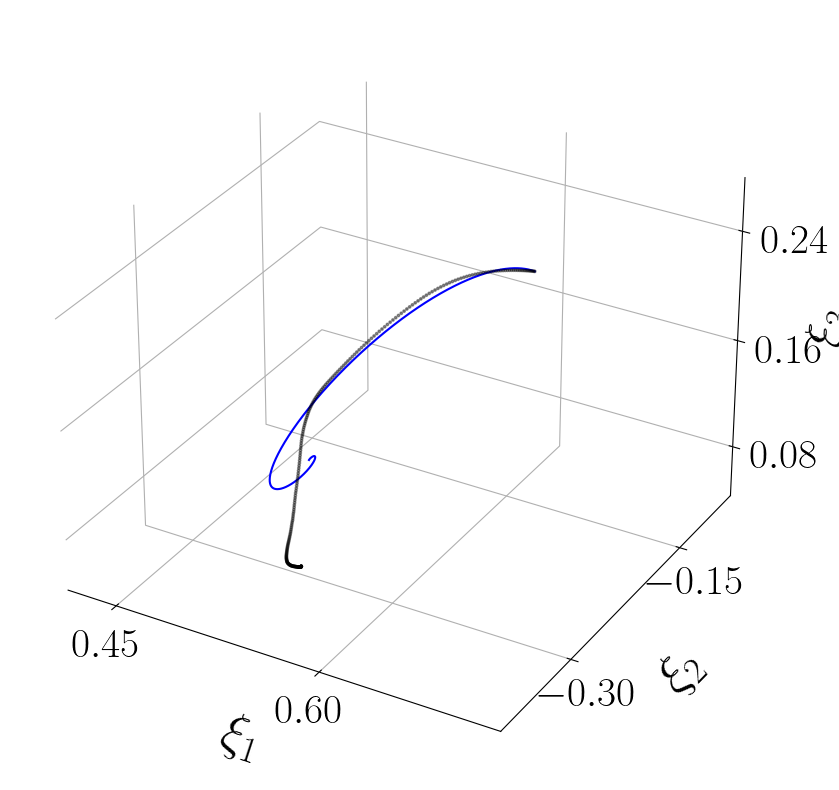

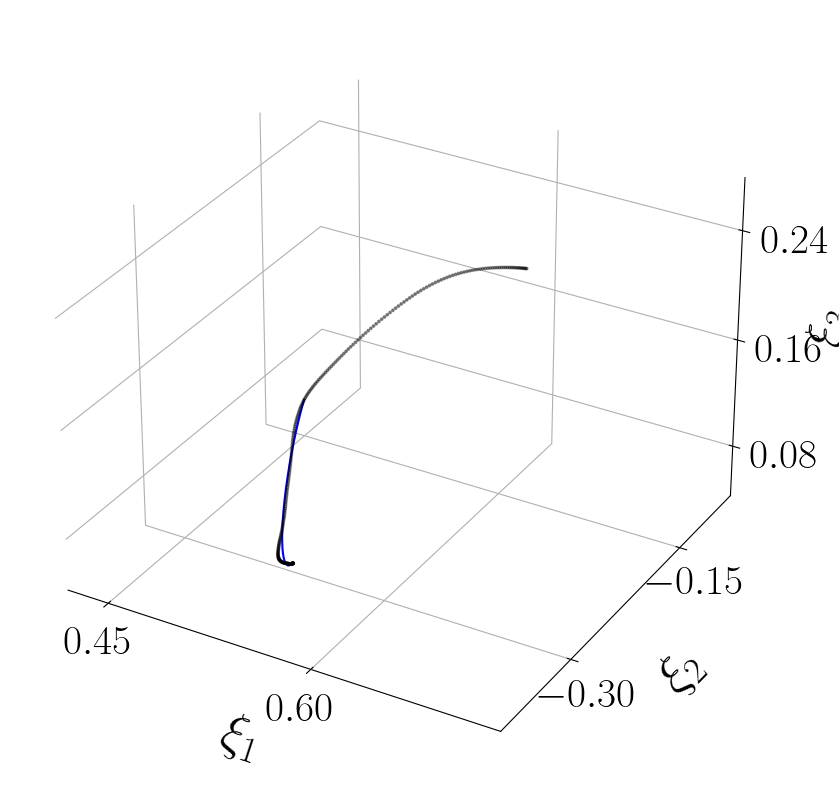

In [13]:
# # evaluate results
x_test_list_1 = []
x_test_list_2 = []

for x_0 in x_init:
    x_test_list_1.append(sim(x_0.reshape(1, -1), x_att_1, A_1, dt=0.005))
    x_test_list_2.append(sim(x_2[0, :].reshape(1, -1), x_att_2, A_2, dt=0.005))


# plot results
from src.lpvds.src.util import plot_tools
plot_tools.plot_ds_3d(x, x_test_list_1)
plot_tools.plot_ds_3d(x, x_test_list_2)
plt.show()

